<a href="https://colab.research.google.com/github/xiziqiao/SpikingNN/blob/main/GSC_speech2spike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install speech2spikes

In [4]:
# Importing necessary libraries
import torchaudio
import torch
import os
from torch.utils.data import Dataset

In [5]:
from speech2spikes import S2S

In [6]:
# URL for the Google Speech Commands dataset
gsc_url = 'http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz'

In [7]:
# Destination path
destination_path = '/content/speech_commands_v0.02.tar.gz'

# Download the dataset (this might take a little while)
!wget {gsc_url} -O {destination_path}

# Extract the dataset
!mkdir '/content/gsc_data'
!tar -xf {destination_path} -C '/content/gsc_data'

--2023-12-31 20:10:19--  http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.69.207, 173.194.79.207, 108.177.96.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.69.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2428923189 (2.3G) [application/gzip]
Saving to: ‘/content/speech_commands_v0.02.tar.gz’

/content/speech_com 100%[===================>]   2.26G  42.1MB/s    in 58s     

2023-12-31 20:11:16 (40.3 MB/s) - ‘/content/speech_commands_v0.02.tar.gz’ saved [2428923189/2428923189]



In [8]:
!ls /content/gsc_data


_background_noise_  down     go       marvin  README.md  testing_list.txt     visual
backward	    eight    happy    nine    right	 three		      wow
bed		    five     house    no      seven	 tree		      yes
bird		    follow   learn    off     sheila	 two		      zero
cat		    forward  left     on      six	 up
dog		    four     LICENSE  one     stop	 validation_list.txt


In [9]:
!ls /content/gsc_data/backward/

0165e0e8_nohash_0.wav	3ce4910e_nohash_0.wav  87070229_nohash_3.wav   c50f55b8_nohash_11.wav
017c4098_nohash_0.wav	3ce4910e_nohash_1.wav  8769c34c_nohash_0.wav   c50f55b8_nohash_12.wav
017c4098_nohash_1.wav	3ce4910e_nohash_2.wav  8769c34c_nohash_1.wav   c50f55b8_nohash_13.wav
017c4098_nohash_2.wav	3ce4910e_nohash_3.wav  8769c34c_nohash_2.wav   c50f55b8_nohash_14.wav
017c4098_nohash_3.wav	3d794813_nohash_0.wav  8769c34c_nohash_3.wav   c50f55b8_nohash_15.wav
017c4098_nohash_4.wav	3d794813_nohash_1.wav  878befa7_nohash_0.wav   c50f55b8_nohash_16.wav
02ade946_nohash_0.wav	3d794813_nohash_2.wav  878befa7_nohash_1.wav   c50f55b8_nohash_17.wav
02ade946_nohash_1.wav	3d794813_nohash_3.wav  878befa7_nohash_2.wav   c50f55b8_nohash_18.wav
02ade946_nohash_2.wav	3d794813_nohash_4.wav  878befa7_nohash_3.wav   c50f55b8_nohash_19.wav
02ade946_nohash_3.wav	3d86b69a_nohash_0.wav  879a2b38_nohash_0.wav   c50f55b8_nohash_1.wav
02ade946_nohash_4.wav	3d86b69a_nohash_1.wav  879a2b38_nohash_1.wav   c50f55b8_noh

In [18]:
# Define the path to a specific audio file from the GSC dataset
audio_file = '0165e0e8_nohash_0.wav'
audio_path = f'/content/gsc_data/backward/{audio_file}'

# Load the audio file
waveform, sample_rate = torchaudio.load(audio_path)
print(waveform.shape)

torch.Size([1, 16000])


In [11]:
s2s = S2S()
label = torch.tensor([1])
batch = [(waveform, label)]

In [12]:
spike_trains = s2s(batch)


In [13]:
print(type(spike_trains))

<class 'tuple'>


In [14]:
spike_trains[0]

tensor([[[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0., -1.],
          ...,
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ..., -1.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]]])

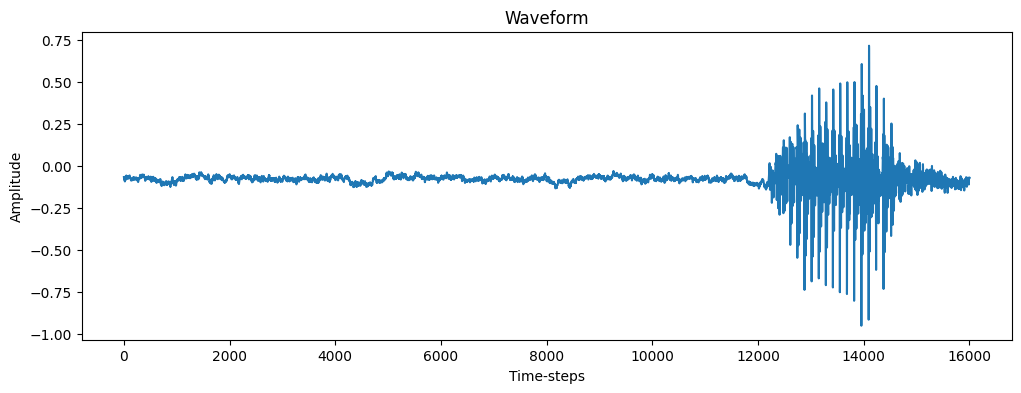

In [15]:
import matplotlib.pyplot as plt
import torchaudio


waveform, sample_rate = torchaudio.load(audio_path)

# Plotting the waveform
plt.figure(figsize=(12, 4))
plt.plot(waveform.t().numpy())
plt.title('Waveform')
plt.ylabel('Amplitude')
plt.xlabel('Time-steps')
plt.show()

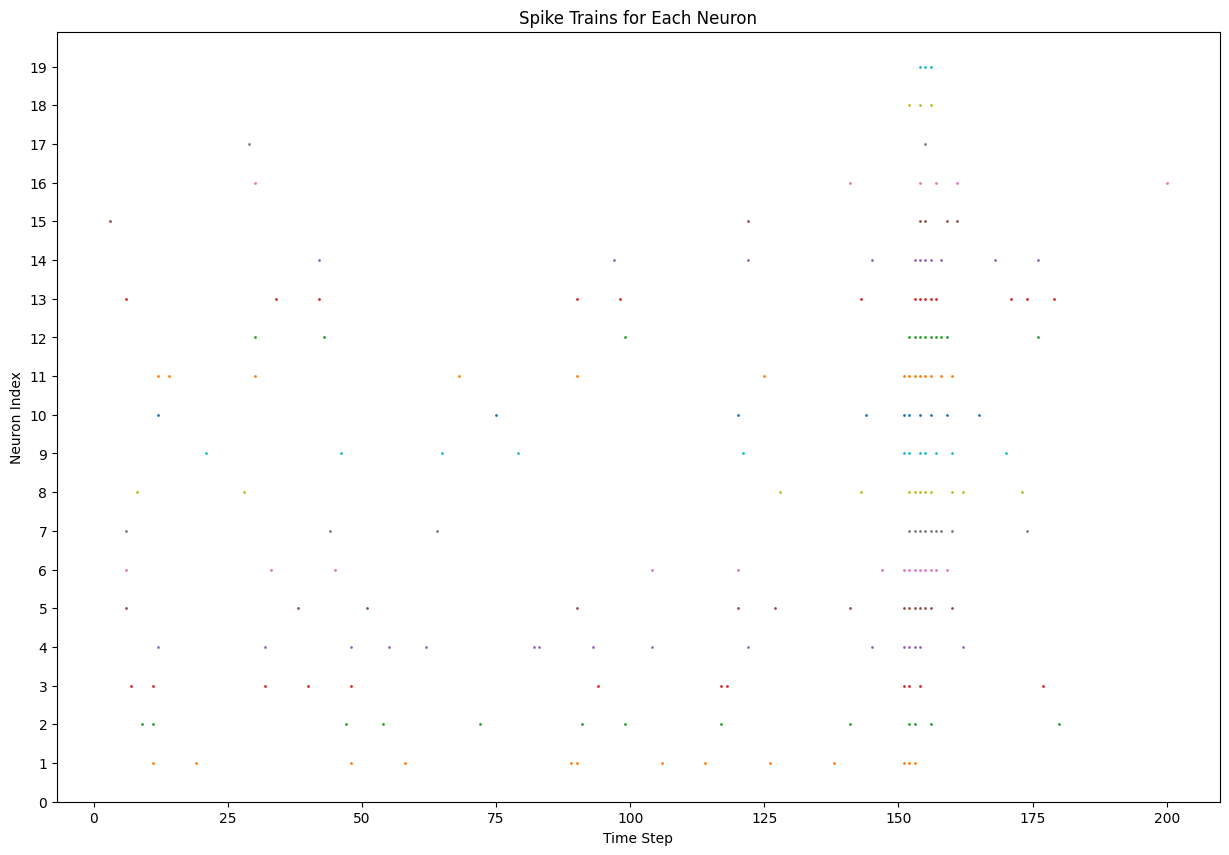

In [16]:
import matplotlib.pyplot as plt
import numpy as np


spikes, targets = spike_trains

# Convert the spikes to a numpy array
spikes_np = spikes.numpy()


# This reduces the (1, 1, 20, 201) array to a (20, 201) array, batch and channel dimensions are not needed
squeezed_spikes = spikes_np.squeeze()

# Plotting
plt.figure(figsize=(15, 10))

# Iterate over each neuron's spike train (3rd dimension)
for i, neuron_spikes in enumerate(squeezed_spikes):
    # Time steps are the same for all neurons, so it's just a range of the length of the time dimension
    time_steps = np.arange(neuron_spikes.shape[-1])  # or simply use 201 here

    # Find the indices (timesteps) where there are spikes
    spike_indices = np.where(neuron_spikes > 0)[0]  # Get the indices of spikes

    # Plot spikes for this neuron. Adjusting 'i' so each neuron's spikes are plotted on a separate line.
    plt.scatter(spike_indices, np.full_like(spike_indices, i), label=f'Neuron {i}', s=1)

# Enhance plot
plt.title('Spike Trains for Each Neuron')
plt.xlabel('Time Step')
plt.ylabel('Neuron Index')
plt.yticks(np.arange(squeezed_spikes.shape[0]))  # Set y-ticks to be each neuron
plt.show()
